In [30]:
%matplotlib notebook
#from results_poller import results_plots, reo_optimize_localhost 
# reo_optimize_development, reo_inputs, reo_optimize, 
#from results_poller import reo_optimize_localhost
#from offgrid_utils import *
#from utils import parse_properties
import pandas as pd
import numpy as np
import pickle
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import os
import plotly.express as px
import plotly.graph_objects as go
import copy
from csv import DictWriter
from offgrid_utils import *

- Examine posts
- Examine loads
- Examine outputs

## Posts

In [15]:
post_path = 'tests/single_load/REopt Posts/load_types/'
post_name = 'netloadstor_pvprod' 

In [19]:
with open(os.path.join(post_path, post_name + ".json"), 'r') as fp:
    post = json.load(fp)

post;

In [17]:
post['Scenario']['Site']['PV']

{'min_kw': 0,
 'max_kw': 0,
 'existing_kw': 6.0,
 'installed_cost_us_dollars_per_kw': 1600.0,
 'om_cost_us_dollars_per_kw': 16.0,
 'macrs_option_years': 5,
 'federal_itc_pct': 0.26,
 'array_type': 1,
 'tilt': 10,
 'can_curtail': True,
 'prod_factor_series_kw': [0.0074,
  0.007464912,
  0.007561404,
  0.007464912,
  0.007441667,
  0.007403509,
  0.007403509,
  0.020641667,
  0.17472807,
  0.152491667,
  0.146885965,
  0.134008772,
  0.187758333,
  0.081701754,
  0.064657895,
  0.010433333,
  0.007324561,
  0.007391667,
  0.007429825,
  0.007368421,
  0.00725,
  0.007184211,
  0.007183333,
  0.007280702,
  0.007377193,
  0.007368421,
  0.00745614,
  0.007491228,
  0.007324561,
  0.007429825,
  0.011675439,
  0.076116667,
  0.158342105,
  0.099558333,
  0.154008772,
  0.115789474,
  0.11305,
  0.110245614,
  0.0421,
  0.009491228,
  0.007701754,
  0.007783333,
  0.007403509,
  0.007333333,
  0.007403509,
  0.007608333,
  0.00804386,
  0.007877193,
  0.007591667,
  0.007622807,
  0.0074824

# Results

In [21]:
results_path = 'tests/single_load/REopt Results/load_types/'
results_name = 'netloadstor_pvprod' 

In [22]:
with open(os.path.join(results_path, results_name + ".json"), 'r') as fp:
    results = json.load(fp)

results;

In [28]:
results['inputs']['Scenario'] #['Site'] #['LoadProfile']

{'Site': {'latitude': 44.15,
  'longitude': -73.25,
  'address': None,
  'land_acres': None,
  'roof_squarefeet': 900.0,
  'elevation_ft': 0.0,
  'renewable_electricity_min_pct': None,
  'renewable_electricity_max_pct': None,
  'co2_emissions_reduction_min_pct': None,
  'co2_emissions_reduction_max_pct': None,
  'include_exported_elec_emissions_in_total': True,
  'include_exported_renewable_electricity_in_total': True,
  'Financial': {'om_cost_escalation_pct': 0.025,
   'escalation_pct': 0.023,
   'generator_fuel_escalation_pct': 0.027,
   'boiler_fuel_escalation_pct': 0.034,
   'chp_fuel_escalation_pct': 0.034,
   'newboiler_fuel_escalation_pct': 0.034,
   'offtaker_tax_pct': 0.26,
   'offtaker_discount_pct': 0.083,
   'third_party_ownership': True,
   'owner_tax_pct': 0.26,
   'owner_discount_pct': 0.083,
   'analysis_years': 25,
   'value_of_lost_load_us_dollars_per_kwh': 100.0,
   'microgrid_upgrade_cost_pct': 0.3,
   'other_capital_costs_us_dollars': 0.0,
   'other_annual_costs_us

## Graph outputs

In [32]:
# Set timeframe 
xlim_lower = pd.Timestamp('2018-05-05 00:00:00') # x_axis[outage_start_hour - 10*24] 
xlim_upper = pd.Timestamp('2018-05-07 00:00:00') # x_axis[outage_start_hour + 7*24+10*24] #

<IPython.core.display.Javascript object>


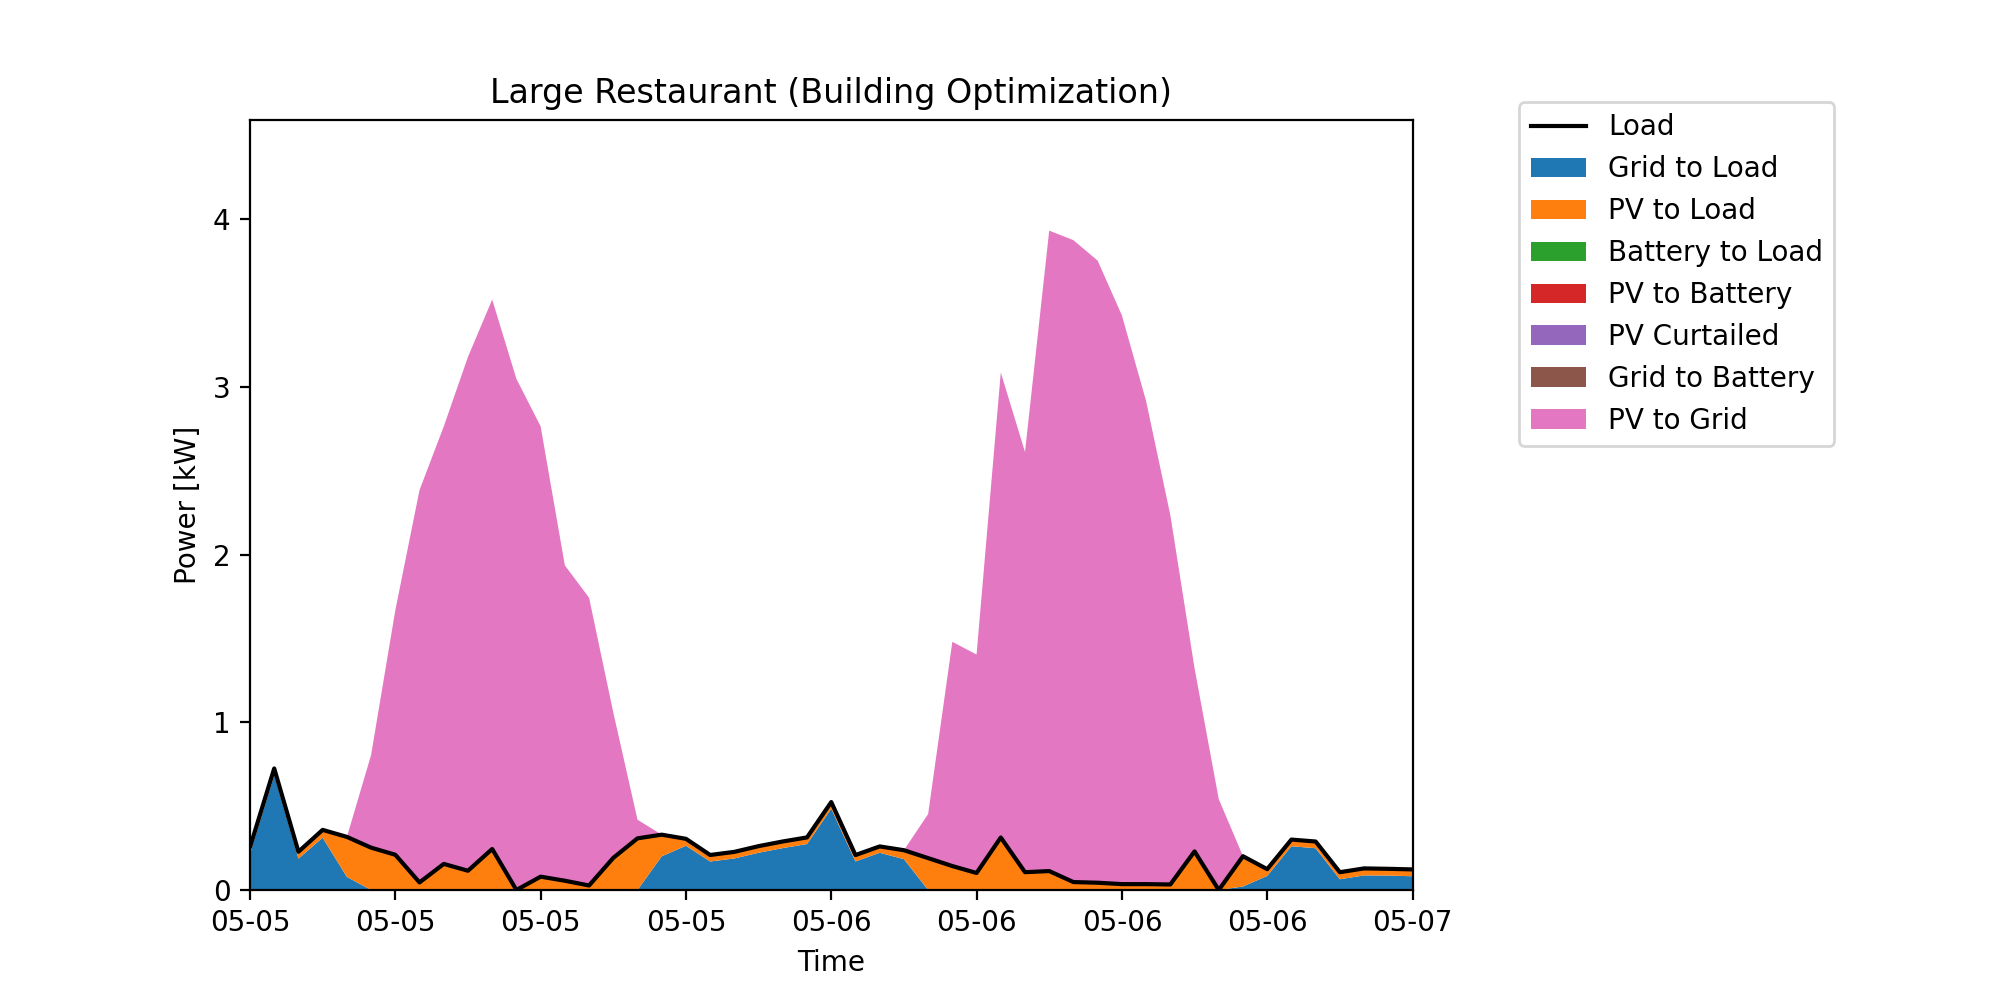

In [33]:
# Dispatch and other outputs
api_response = results

ts=pd.date_range("1/1/2018 00:00", periods=8760, freq="1H")
output_df = pd.DataFrame(index=ts)
output_df['load'] = api_response['outputs']['Scenario']['Site']['LoadProfile']['year_one_electric_load_series_kw']
output_df['grid_to_load'] = api_response['outputs']['Scenario']['Site']['ElectricTariff']['year_one_to_load_series_kw']
output_df['grid_to_battery'] = api_response['outputs']['Scenario']['Site']['ElectricTariff']['year_one_to_battery_series_kw']

if api_response['outputs']['Scenario']['Site']['Storage']['size_kw'] > 0:
    output_df['batt_grid'] = api_response['outputs']['Scenario']['Site']['Storage']['year_one_to_grid_series_kw']
    output_df['batt_discharge'] = api_response['outputs']['Scenario']['Site']['Storage']['year_one_to_load_series_kw']
    output_df['batt_soc'] = api_response['outputs']['Scenario']['Site']['Storage']['year_one_soc_series_pct']
else: 
    output_df['batt_grid'] = [0.0]*8760
    output_df['batt_discharge'] = [0.0]*8760
    output_df['batt_soc'] = [0.0]*8760
    
if api_response['outputs']['Scenario']['Site']['PV']['size_kw'] > 0:
    output_df['pv_to_load'] = api_response['outputs']['Scenario']['Site']['PV']['year_one_to_load_series_kw']
    output_df['pv_to_batt'] = api_response['outputs']['Scenario']['Site']['PV']['year_one_to_battery_series_kw']
    output_df['pv_grid'] = api_response['outputs']['Scenario']['Site']['PV']['year_one_to_grid_series_kw']
    output_df['pv_curtailed'] = api_response['outputs']['Scenario']['Site']['PV']['year_one_curtailed_production_series_kw']
else:
    output_df['pv_to_load'] = [0.0]*8760
    output_df['pv_to_batt'] = [0.0]*8760
    output_df['pv_grid'] = [0.0]*8760
    output_df['pv_curtailed'] = [0.0]*8760

# Plot dispatch
x_axis = output_df.index

stacked_series = [output_df['grid_to_load'], output_df['pv_to_load'], output_df['batt_discharge'], 
                          output_df['pv_to_batt'], output_df['pv_curtailed'], output_df['grid_to_battery'],
                          output_df['pv_grid']
                         ]
stacked_series_labels = ['Grid to Load', 'PV to Load', 'Battery to Load',
                                 'PV to Battery', 'PV Curtailed', 'Grid to Battery', 'PV to Grid']  

line_series = [output_df['load']] 
line_series_labels = ['Load']
line_styles = ['-'] 
line_colors = ['k']

plot_stacked_area(x_axis, stacked_series, stacked_series_labels, line_series, line_series_labels, 
                  line_styles, line_colors, title='Large Restaurant (Building Optimization)', x=10, y=5, xlim=[xlim_lower, xlim_upper])

# plt.savefig('saved_results/{}/0_results_graphs/test_save.png'.format(project_name))